In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Tư duy tính toán/ds107


/content/drive/MyDrive/Tư duy tính toán/ds107


In [3]:
!pip install torchmetrics
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split as tts
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
# Preprocessing function
def preprocess_data(image_path: Path):
    image_path_list = list(image_path.glob("*/*.jpg")) + list(image_path.glob("*/*.jpeg")) + \
                      list(image_path.glob("*/*.png")) + list(image_path.glob("*/*.JPG")) + \
                      list(image_path.glob("*/*.webp"))

    print(f'Total Images = {len(image_path_list)}')

    classes = sorted(os.listdir(image_path))

    img_path_and_label = {'img_path': [], 'label': []}
    for img_pth in image_path_list:
        img_path_and_label['img_path'].append(img_pth)
        img_path_and_label['label'].append(img_pth.parent.stem)

    df_path_and_label = pd.DataFrame(img_path_and_label)
    X = df_path_and_label.drop('label', axis=1)
    y = df_path_and_label['label']

    SEED = 42
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=SEED, stratify=y)

    label_map = {label: idx for idx, label in enumerate(classes)}
    y_train_array = np.array(y_train.map(label_map))
    y_test_array = np.array(y_test.map(label_map))
    y_train_torch = torch.from_numpy(y_train_array)
    y_test_torch = torch.from_numpy(y_test_array)

    weights = ResNet50_Weights.DEFAULT
    auto_transforms = weights.transforms()
    images_train = [None] * len(X_train)

    for i, (_,img_path_train) in enumerate(X_train.iterrows()):
        img_train = Image.open(img_path_train[0]).convert('RGB')
        images_train[i] = auto_transforms(img_train)

    images_test = [None] * len(X_test)

    for i, (_, img_path_test) in enumerate(X_test.iterrows()):
        img_test = Image.open(img_path_test[0]).convert('RGB')
        images_test[i] = auto_transforms(img_test)

    X_train_torch = torch.stack(images_train)
    X_test_torch = torch.stack(images_test)

    return X_train_torch, X_test_torch, y_train_torch, y_test_torch, classes, weights

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

# Train step function
def train_step(model, dataloader, loss_fn, optimizer, device, num_classes):
    model.train()
    train_loss = 0.
    accuracy_train = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_prob = torch.softmax(y_pred_logit, dim=1)
        accuracy_train.update(y_pred_prob, y)

    train_loss /= len(dataloader)
    train_accuracy = accuracy_train.compute()
    accuracy_train.reset()

    return train_loss, train_accuracy

# Test step function
def test_step(model, dataloader, loss_fn, device, num_classes):
    model.eval()
    test_loss = 0.
    accuracy_test = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            test_loss += loss.item()

            y_pred_prob = torch.softmax(y_pred_logit, dim=1)
            accuracy_test.update(y_pred_prob, y)

    test_loss /= len(dataloader)
    test_accuracy = accuracy_test.compute()
    accuracy_test.reset()

    return test_loss, test_accuracy

# Save checkpoint function
def save_checkpoint(filename, model, loss, epoch, optimizer):
    state = {'model': model.state_dict(), 'loss': loss, 'epoch': epoch, 'optimizer': optimizer.state_dict()}
    torch.save(state, filename)

# Training function
def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, num_classes):
    results = {'train_loss': [], 'train_accuracy': [], 'test_loss': [], 'test_accuracy': []}
    best_test_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model, train_dataloader, loss_fn, optimizer, device, num_classes)
        test_loss, test_accuracy = test_step(model, test_dataloader, loss_fn, device, num_classes)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            save_checkpoint('best_model.pt', model, best_test_loss, epoch, optimizer)

        print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')

        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['test_loss'].append(test_loss)
        results['test_accuracy'].append(test_accuracy)

    return results

# Main function
def main(image_path: str, batch_size: int = 4, epochs: int = 100, learning_rate: float = 0.01, weight_decay: float = 0.1):
    image_path = Path(image_path)
    X_train_torch, X_test_torch, y_train_torch, y_test_torch, classes, weights = preprocess_data(image_path)

    train_dataset = CustomDataset(X_train_torch, y_train_torch)
    test_dataset = CustomDataset(X_test_torch, y_test_torch)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = resnet50(weights=weights)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(in_features=2048, out_features=len(classes), bias=True)
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    summary(model, input_size=(batch_size, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'])

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    results = train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, len(classes))

results= main("/content/drive/MyDrive/Tư duy tính toán/ds107/dataset_split/Multiclass/train")


Total Images = 1400


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 1.8598 | Train Accuracy: 0.4134 | Test Loss: 1.1966 | Test Accuracy: 0.6000
Epoch 2/100 | Train Loss: 1.3685 | Train Accuracy: 0.5759 | Test Loss: 1.0503 | Test Accuracy: 0.6250
Epoch 3/100 | Train Loss: 1.0565 | Train Accuracy: 0.6411 | Test Loss: 1.5053 | Test Accuracy: 0.5893
Epoch 4/100 | Train Loss: 1.0791 | Train Accuracy: 0.6643 | Test Loss: 1.0328 | Test Accuracy: 0.6643
Epoch 5/100 | Train Loss: 1.0516 | Train Accuracy: 0.6536 | Test Loss: 0.9207 | Test Accuracy: 0.6929
Epoch 6/100 | Train Loss: 0.9348 | Train Accuracy: 0.6929 | Test Loss: 0.8060 | Test Accuracy: 0.7214
Epoch 7/100 | Train Loss: 0.9150 | Train Accuracy: 0.6938 | Test Loss: 0.7639 | Test Accuracy: 0.7321
Epoch 8/100 | Train Loss: 0.9500 | Train Accuracy: 0.6946 | Test Loss: 1.1100 | Test Accuracy: 0.6714
Epoch 9/100 | Train Loss: 0.9945 | Train Accuracy: 0.6848 | Test Loss: 1.1114 | Test Accuracy: 0.6750
Epoch 10/100 | Train Loss: 0.9203 | Train Accuracy: 0.7107 | Test Loss: 1.2524 | T

Total Test Images = 350
Accuracy: 73.14%
Classification Report:
                                   precision    recall  f1-score   support

            Bacterial Red disease       0.80      0.56      0.66        50
Bacterial diseases - Aeromoniasis       0.78      0.72      0.75        50
           Bacterial gill disease       0.71      0.84      0.77        50
   Fungal diseases Saprolegniasis       0.72      0.68      0.70        50
                     Healthy Fish       0.88      0.84      0.86        50
               Parasitic diseases       0.77      0.60      0.67        50
Viral diseases White tail disease       0.58      0.88      0.70        50

                         accuracy                           0.73       350
                        macro avg       0.75      0.73      0.73       350
                     weighted avg       0.75      0.73      0.73       350

Test Accuracy: 0.7314


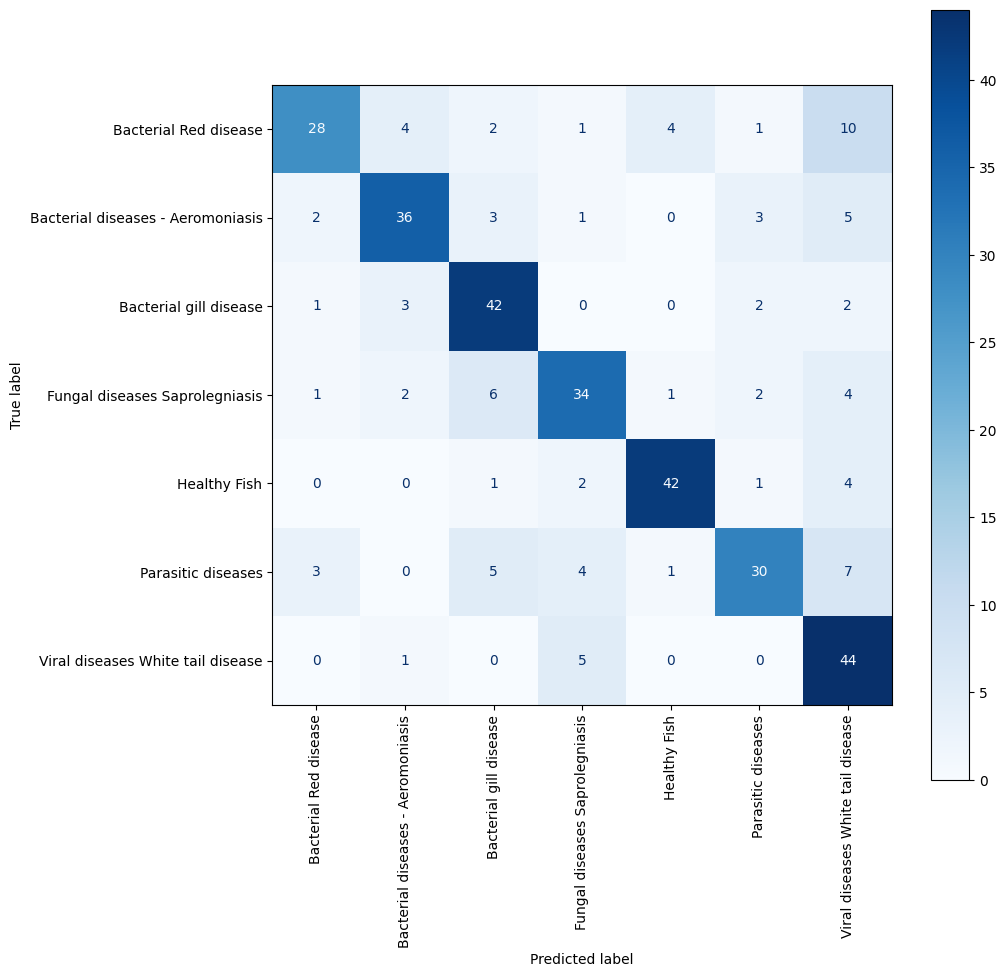

In [11]:

def preprocess_test_data(test_image_path: Path, classes, weights):
    image_path_list = list(test_image_path.glob("*/*.jpg")) + list(test_image_path.glob("*/*.jpeg")) + \
                      list(test_image_path.glob("*/*.png")) + list(test_image_path.glob("*/*.JPG")) + \
                      list(test_image_path.glob("*/*.webp"))

    print(f'Total Test Images = {len(image_path_list)}')

    img_path_and_label = {'img_path': [], 'label': []}
    for img_pth in image_path_list:
        img_path_and_label['img_path'].append(img_pth)
        img_path_and_label['label'].append(img_pth.parent.stem)

    df_path_and_label = pd.DataFrame(img_path_and_label)
    X_test = df_path_and_label.drop('label', axis=1)
    y_test = df_path_and_label['label']

    label_map = {label: idx for idx, label in enumerate(classes)}
    y_test_array = np.array(y_test.map(label_map))
    y_test_torch = torch.from_numpy(y_test_array)

    auto_transforms = weights.transforms()
    images_test = [None] * len(X_test)

    for i, (_, img_path_test) in enumerate(X_test.iterrows()):
        img_test = Image.open(img_path_test[0]).convert('RGB')
        images_test[i] = auto_transforms(img_test)

    X_test_torch = torch.stack(images_test)

    return X_test_torch, y_test_torch
def evaluate_model(model, test_dataloader, device, num_classes, classes):
    model.eval()
    accuracy_test = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=num_classes).to(device)
    y_true = []
    y_pred = []

    with torch.no_grad():  # Sử dụng torch.no_grad() để tiết kiệm bộ nhớ
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            y_pred_prob = torch.softmax(y_pred_logit, dim=1)
            y_pred_label = y_pred_prob.argmax(dim=1)

            accuracy_test.update(y_pred_prob, y)
            confusion_matrix.update(y_pred_prob, y)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(y_pred_label.cpu().numpy())

    test_accuracy = accuracy_test.compute()
    cm = confusion_matrix.compute().cpu().numpy()
    accuracy_test.reset()
    confusion_matrix.reset()

    # Convert to numpy arrays for compatibility with sklearn metrics
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=classes))

    return test_accuracy, cm

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.show()
def evaluate_model_on_test_data(model_weights_path: str, test_image_path: str, batch_size: int = 4):
    test_image_path = Path(test_image_path)

    # Load model weights and classes
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    classes = sorted([d.name for d in os.scandir(test_image_path) if d.is_dir()])
    model.fc = nn.Linear(in_features=2048, out_features=len(classes), bias=True)
    model.load_state_dict(torch.load(model_weights_path)['model'])
    model.to(device)

    # Preprocess test data
    X_test_torch, y_test_torch = preprocess_test_data(test_image_path, classes, ResNet50_Weights.DEFAULT)

    test_dataset = CustomDataset(X_test_torch, y_test_torch)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

    # Evaluate the model
    test_accuracy, cm = evaluate_model(model, test_dataloader, device, len(classes), classes)

    # Print accuracy and plot confusion matrix
    print(f'Test Accuracy: {test_accuracy:.4f}')
    plot_confusion_matrix(cm, classes)



# Example usage:
evaluate_model_on_test_data("/content/drive/MyDrive/Tư duy tính toán/ds107/best_model.pt", "/content/drive/MyDrive/Tư duy tính toán/ds107/dataset_split/Multiclass/val")